# Exploratory data analysis & Simple Classifiers
## Date created: 1 March 2021
### Quick exploration of datasets considered for thesis research.
### Currently contains analyses of: Blog Authorship Corpus

In [1]:
%matplotlib inline

# Import statements
import os # for directory operations
import numpy as np # for numerical/linear algebra methods
import pandas as pd # for data(frame) processing
import pdb # for debudding
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for cool plotting
import re # for regular expression
import nltk # natural language processing toolkit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from langdetect import detect, detect_langs # for language detection


In [2]:
# TODO: write specification scheme for type of "simple" classifier to build and test?
# Maybe just have the notebook build, train, and test all simple ones, i.e., Logit+ n-grams, Logit + grams + linguistic features, etc.
# Specifiy trian-test splits
# What else? --> Label to predict (e.g., age cat, age number, gender, astrological sign, topic)
SEED = 420
MAX_N_GRAM = 2
TEST_SPLIT = 0.2

In [3]:
# Set seed for reproducibility 
np.random.seed(SEED)

In [4]:
# Get pathname of dataset
for dirname, _, filenames in os.walk("../data/blogs_kaggle"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/blogs_kaggle/.DS_Store
../data/blogs_kaggle/blogtext.csv


In [5]:
# Read and load dataset
data = pd.read_csv("../data/blogs_kaggle/blogtext.csv")

In [6]:
# Quick sample/overview of dataframe structure
data.head(15)
# TODO: Remove non-English texts --> See row 2 --> See DialoGPT paper for tips on filtering out languages

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
5,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",I had an interesting conversation...
6,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Somehow Coca-Cola has a way of su...
7,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004","If anything, Korea is a country o..."
8,3581210,male,33,InvestmentBanking,Aquarius,"10,June,2004",Take a read of this news article ...
9,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",I surf the English news sites a l...


In [7]:
# Check for missing values/NAs in all variables
data.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [8]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [9]:
# TODO: comment out this cell when running analyses on full dataset.
# Take subset of data for faster testing
data = data.head(10000)

In [10]:
# Shape (i.e., number of datapoints and variables, respectively) of dataframe
data.shape

(10000, 7)

## Exploratory analysis

In [11]:
data.describe(include = ['object', 'bool'])

,gender,topic,sign,date,text
count,10000,10000,10000,10000,10000
unique,2,26,12,718,9949
top,male,indUnk,Aries,"05,August,2004",
freq,5916,3287,4198,2329,13


In [12]:
# Convert all columns (except ID and date) to object type
data['age'] = data['age'].astype(object)

Text(0.5, 1.0, 'Unconditional Age Distribution')

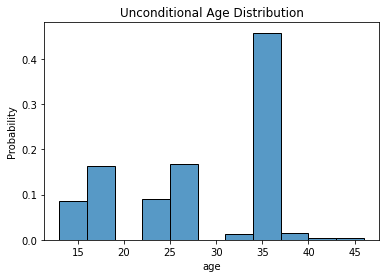

In [13]:
# Age distribution, unconditional
sns.histplot(data, x = "age", binwidth = 3, stat = "probability")
plt.title("Unconditional Age Distribution")

Text(0.5, 1.0, 'Age Distribution, Conditioned On Gender')

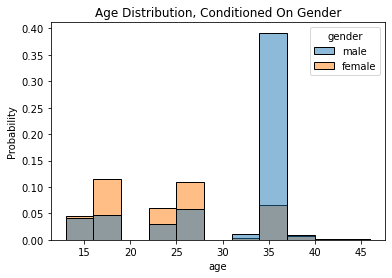

In [14]:
# Age distribution, conditioned on gender
sns.histplot(data, x = "age", hue = "gender", binwidth = 3, stat = "probability")
plt.title("Age Distribution, Conditioned On Gender")

Text(0.5, 1.0, 'Distribution of Astrological Signs')

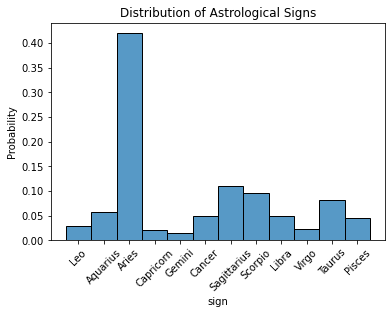

In [15]:
sns.histplot(data, x = 'sign', stat = 'probability')
plt.xticks(rotation=45)
plt.title("Distribution of Astrological Signs")

Text(0.5, 1.0, 'Distribution of Topics')

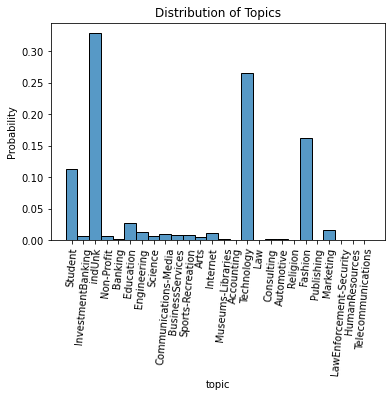

In [16]:
sns.histplot(data, x = 'topic', stat = 'probability')
plt.xticks(rotation=85)
plt.title("Distribution of Topics")

## Data cleaning / preprocessing

In [17]:
# Removing all unwanted text/characters from data['text'] column

# Remove all non-alphabetical characters
data['clean_data'] = data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ', x))

In [18]:
# Make all letters lower case
data['clean_data'] = data['clean_data'].apply(lambda x: x.lower())

In [19]:
# Remove white space from beginning and end of string
data['clean_data'] = data['clean_data'].apply(lambda x: x.strip())

In [20]:
# Remove instances empty strings
before_rm_empty = len(data)
data.drop(data[data.clean_data == ''].index, inplace = True)

print(f'{before_rm_empty - len(data)} instances removed.')

43 instances removed.


In [66]:
# Remove texts that are probably not English by filtering blogs that dont contain at least one of the top 50 most used English words

# create dict with most common English words
top_en_words = {}
with open('../data/wordlists/top1000english.txt') as f:
    count = 1
    for line in f:
        key = line.split()[0].lower()
        top_en_words[key] = count
        count += 1
        
        # Stop at top 50 words. Idea taken from DialoGPT paper.
        if count > 50:
            break


data['top_50_en'] = data['clean_data'].apply(lambda x : True if not set(x.split()).isdisjoint(top_en_words) else False)

def top_lang_detect(text):
    
    detected_langs = detect_langs(text)
    
    return detected_langs[0].lang
        

def top_prob_detect(text):
    
    detected_langs = detect_langs(text)
    
    return detected_langs[0].prob

data['top_lang'] = data['clean_data'].apply(top_lang_detect)
data['top_prob'] = data['clean_data'].apply(top_prob_detect)

In [67]:
data

,id,gender,age,topic,sign,date,text,clean_data,top_50_en,detected_langs,top_lang,top_prob
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,...",info has been found pages and mb of pdf files ...,True,"[en, 0.9999961923054654]",en,0.999997
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...,these are the team members drewes van der laag...,True,"[nl, 0.7143457165176873]",nl,0.571428
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...,in het kader van kernfusie op aarde maak je ei...,True,"[en, 0.9999943534574756]",en,0.999996
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!,testing testing,False,"[en, 0.9999927026168345]",en,0.999995
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...,thanks to yahoo s toolbar i can now capture th...,True,"[en, 0.9999980309369944]",en,0.999997
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1705136,female,25,indUnk,Pisces,"19,May,2004",take me home with you forever where I ...,take me home with you forever where i may rest...,True,"[en, 0.9999969406689142]",en,0.999998
9996,1705136,female,25,indUnk,Pisces,"23,June,2004",seductive secretness behind doors warn...,seductive secretness behind doors warning me t...,True,"[en, 0.9999958387003478]",en,0.999998
9997,1705136,female,25,indUnk,Pisces,"21,June,2004",For being so kind to me when I need yo...,for being so kind to me when i need you most f...,True,"[en, 0.9999973417967196]",en,0.999997
9998,1705136,female,25,indUnk,Pisces,"09,June,2004",blurry outside sounds as people mingle...,blurry outside sounds as people mingle and pas...,True,"[en, 0.9999980260258055]",en,0.999997


In [68]:
# Remove rows without one of top50 most common english words
before_top50_removal = len(data)
data.drop(data[data['top_50_en'] == False].index, inplace = True)
print(f"{before_top50_removal - len(data)} instances dropped")

361 instances dropped


In [71]:
before_top_lang = len(data)
data.drop(data[data['top_lang'] != 'en'].index, inplace = True)
print(f'{before_top_lang - len(data)} instances dropped.')

197 instances dropped.


In [72]:
before_top_prob = len(data)
data.drop(data[data['top_prob'] < 0.9].index, inplace = True)
print(f'{before_top_prob - len(data)} instances dropped.')

231 instances dropped.


In [73]:
# Remove stop words
stopwords = set(nltk.corpus.stopwords.words('english')) # use set (hash table) data structure for faster lookup
data['clean_data'] = data['clean_data'].apply(lambda x: ' '.join([words for words in x.split() if words not in stopwords]))

In [74]:
# Check difference: before
print(f"Unprocessed data =====> {data['text'][0]}")
print(81 * "=")
# After
print(f"Cleaned data so far =====> {data['clean_data'][0]}")

Unprocessed data =====>            Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait untill our team leader has processed it and learns html.         
Cleaned data so far =====> info found pages mb pdf files wait untill team leader processed learns html


In [75]:
data['clean_data'][6]

'somehow coca cola way summing things well early flagship jingle like buy world coke tune like teach world sing pretty much summed post woodstock era well add much sales catchy tune korea coke theme urllink stop thinking feel pretty much sums lot korea koreans look relaxed couple stopped thinking started feeling course high regard education math logic deep think many koreans really like work emotion anything else westerners seem sublimate moreso least display different way maybe scratch westerners koreans probably pretty similar context different anyways think losing korea repeat stop thinking feel stop thinking feel stop thinking feel everything alright'

In [76]:
# Drop columns that are uninformative for writing style (i.e., ID and date)
data.drop(['id', 'date'], axis = 1, inplace = True)

In [77]:
# Add labels for age categories
def age_to_cat(age):
    '''Returns age category label for given age number.'''
    
    if 13 <= int(age) <= 17:
        return '13-27'
    elif 23 <= int(age) <= 27:
        return '23-27'
    elif 33 <= int(age) <= 47:
        return '33-47'
    else:
        raise ValueError("Given age not in one of pre-defined age groups.")


data['age_cat'] = data['age'].apply(age_to_cat)

In [78]:
data.head()

,gender,age,topic,sign,text,clean_data,top_50_en,detected_langs,top_lang,top_prob,age_cat
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,...",info found pages mb pdf files wait untill team...,True,"[en, 0.9999961923054654]",en,0.999997,13-27
2,male,15,Student,Leo,In het kader van kernfusie op aarde...,het kader van kernfusie op aarde maak je eigen...,True,"[en, 0.9999943534574756]",en,0.999996,13-27
4,male,33,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...,thanks yahoo toolbar capture urls popups means...,True,"[en, 0.9999980309369944]",en,0.999997,33-47
5,male,33,InvestmentBanking,Aquarius,I had an interesting conversation...,interesting conversation dad morning talking k...,True,"[en, 0.999998055123966]",en,0.999997,33-47
6,male,33,InvestmentBanking,Aquarius,Somehow Coca-Cola has a way of su...,somehow coca cola way summing things well earl...,True,"[en, 0.9999969315236434]",en,0.999997,33-47


In [79]:
# Merge all possibly interesting labels into one column
data['labels'] = data.apply(lambda col: [col['gender'], str(col['age']), col['topic'], col['sign']], axis = 1)

# Only keep age as label
# data['labels'] = data.apply(lambda col: [str(col['age'])], axis = 1) # TODO: Why keep age as string?
# data['labels'] = data.apply(lambda col: [col['age']], axis = 1)
data['labels'] = data.apply(lambda col: [col['age_cat']], axis = 1)

In [80]:
data.head()

,gender,age,topic,sign,text,clean_data,top_50_en,detected_langs,top_lang,top_prob,age_cat,labels
0,male,15,Student,Leo,"Info has been found (+/- 100 pages,...",info found pages mb pdf files wait untill team...,True,"[en, 0.9999961923054654]",en,0.999997,13-27,[13-27]
2,male,15,Student,Leo,In het kader van kernfusie op aarde...,het kader van kernfusie op aarde maak je eigen...,True,"[en, 0.9999943534574756]",en,0.999996,13-27,[13-27]
4,male,33,InvestmentBanking,Aquarius,Thanks to Yahoo!'s Toolbar I can ...,thanks yahoo toolbar capture urls popups means...,True,"[en, 0.9999980309369944]",en,0.999997,33-47,[33-47]
5,male,33,InvestmentBanking,Aquarius,I had an interesting conversation...,interesting conversation dad morning talking k...,True,"[en, 0.999998055123966]",en,0.999997,33-47,[33-47]
6,male,33,InvestmentBanking,Aquarius,Somehow Coca-Cola has a way of su...,somehow coca cola way summing things well earl...,True,"[en, 0.9999969315236434]",en,0.999997,33-47,[33-47]


In [81]:
# Reduce dataframe to only contain cleaned blogs and list of labels
data = data[['clean_data', 'labels']]


In [82]:
data.head()

,clean_data,labels
0,info found pages mb pdf files wait untill team...,[13-27]
2,het kader van kernfusie op aarde maak je eigen...,[13-27]
4,thanks yahoo toolbar capture urls popups means...,[33-47]
5,interesting conversation dad morning talking k...,[33-47]
6,somehow coca cola way summing things well earl...,[33-47]


## Classification

In [83]:
# Split data into features/ X and labels / Y 
X = data['clean_data']
Y = data['labels']

### Bi-gram and tri-gram models

In [84]:
# bi-gram model
vectorizer = CountVectorizer(binary = True, ngram_range = (1, MAX_N_GRAM))

# fit model
X = vectorizer.fit_transform(X)

In [85]:
# check out a sample of the uni- and bigrams
print(vectorizer.get_feature_names()[:10])

['aa', 'aa amazing', 'aa compared', 'aa keeps', 'aa nice', 'aa sd', 'aaa', 'aaa come', 'aaa discount', 'aaa joe']


In [86]:
# Get label counts
label_counts = {}

for labels in data.labels.values:
    for label in labels:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

In [87]:
label_counts

{'13-27': 2326, '33-47': 4439, '23-27': 2403}

In [88]:
# Binarize the labels for prediction 
binarizer = MultiLabelBinarizer(classes = sorted(label_counts.keys()))

In [89]:
Y = binarizer.fit_transform(data.labels)

In [90]:
label_counts.keys()

dict_keys(['13-27', '33-47', '23-27'])

In [91]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = TEST_SPLIT)

In [92]:
# Fit logistic regression model
model = LogisticRegression(solver = 'lbfgs', multi_class='ovr') #TODO: different solveR?
model = OneVsRestClassifier(model) # TODO: Change this  to multi-class classifier for age cats
model.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='ovr', n_jobs=None,
                                                 penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [93]:
# make predictions on test set
Y_pred = model.predict(X_test)

In [94]:
Y_pred_inversed = binarizer.inverse_transform(Y_pred)
Y_test_inversed = binarizer.inverse_transform(Y_test)

In [95]:
# Evaluate performance
def print_evaluation_scores(labels, preds):
    print(f"Accuracy: {accuracy_score(labels, preds)}")
    print(f"F1 score: {f1_score(labels, preds, average = 'micro')}")
    print(f"Average precision: {average_precision_score(labels, preds, average = 'micro')}")
    print(f"Average recall: {recall_score(labels, preds, average = 'micro')}")

In [96]:
print_evaluation_scores(Y_test, Y_pred)

Accuracy: 0.6406761177753544
F1 score: 0.7206142941523922
Average precision: 0.634507789107616
Average recall: 0.6652126499454744
